# Sales Analysis #

In this project, I am going to answer these five business questions. 
- What was the best month for sales? How much was earned that month?
- What city sold the most product?
- What time should we display advertisemens to maximize the likelihood of customer’s buying product?
- What products are most often sold together?
- What product sold the most? Why do you think it sold the most?

Datasets I am going to work on are provided in [here](https://github.com/KeithGalli/Pandas-Data-Science-Tasks). They contain hundreds of thousands of electronics store purchases broken down by month, product type, cost, purchase address, etc.  Moreover,the questions and the datasets are proposed in this [Youtube video](https://youtu.be/eMOA1pPVUc4). Since I do not see the video, solutions that I will offer are created by myself. 

## Read all datasets and concatnate them

In [3]:
#import libraries that I am going to use 
import pandas as pd 
import glob
import matplotlib.pyplot as plt
import missingno as msno

In [4]:
#there is a dataset for each month. So, I'll get 12 datasets. 
files = glob.glob('Sales_*_2019.csv')

In [5]:
dfs = [pd.read_csv(file) for file in files]

In [6]:
sales_data = pd.concat(dfs, ignore_index=True)

In [7]:
sales_data.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
0,176558,USB-C Charging Cable,2,11.95,04/19/19 08:46,"917 1st St, Dallas, TX 75001"
1,NaN,NaN,NaN,NaN,NaN,NaN
2,176559,Bose SoundSport Headphones,1,99.99,04/07/19 22:30,"682 Chestnut St, Boston, MA 02215"
3,176560,Google Phone,1,600,04/12/19 14:38,"669 Spruce St, Los Angeles, CA 90001"
4,176560,Wired Headphones,1,11.99,04/12/19 14:38,"669 Spruce St, Los Angeles, CA 90001"


In [8]:
sales_data.shape

(186850, 6)

#### Summary####
Successfully read all of datasets and concatnated them. I reset the index labels since they are not meaningful. 

## Data Cleaning ##

### Inspection ###

In [9]:
sales_data.describe()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
count,186305,186305,186305,186305,186305,186305
unique,178438,20,10,24,142396,140788
top,Order ID,USB-C Charging Cable,1,11.95,Order Date,Purchase Address
freq,355,21903,168552,21903,355,355


In [10]:
sales_data.dtypes

Order ID            object
Product             object
Quantity Ordered    object
Price Each          object
Order Date          object
Purchase Address    object
dtype: object

All of columns are stored as Object type. This is a reason why ```describe()``` did not return summary statistics(like min and max).
Therefore, I will change dtypes to suitable dtypes later. 

In [11]:
# checking null values
sales_data.isnull().sum(axis=0)

Order ID            545
Product             545
Quantity Ordered    545
Price Each          545
Order Date          545
Purchase Address    545
dtype: int64

In [12]:
sales_data.isnull().all(axis=1).sum()

545

<Figure size 2160x2160 with 0 Axes>

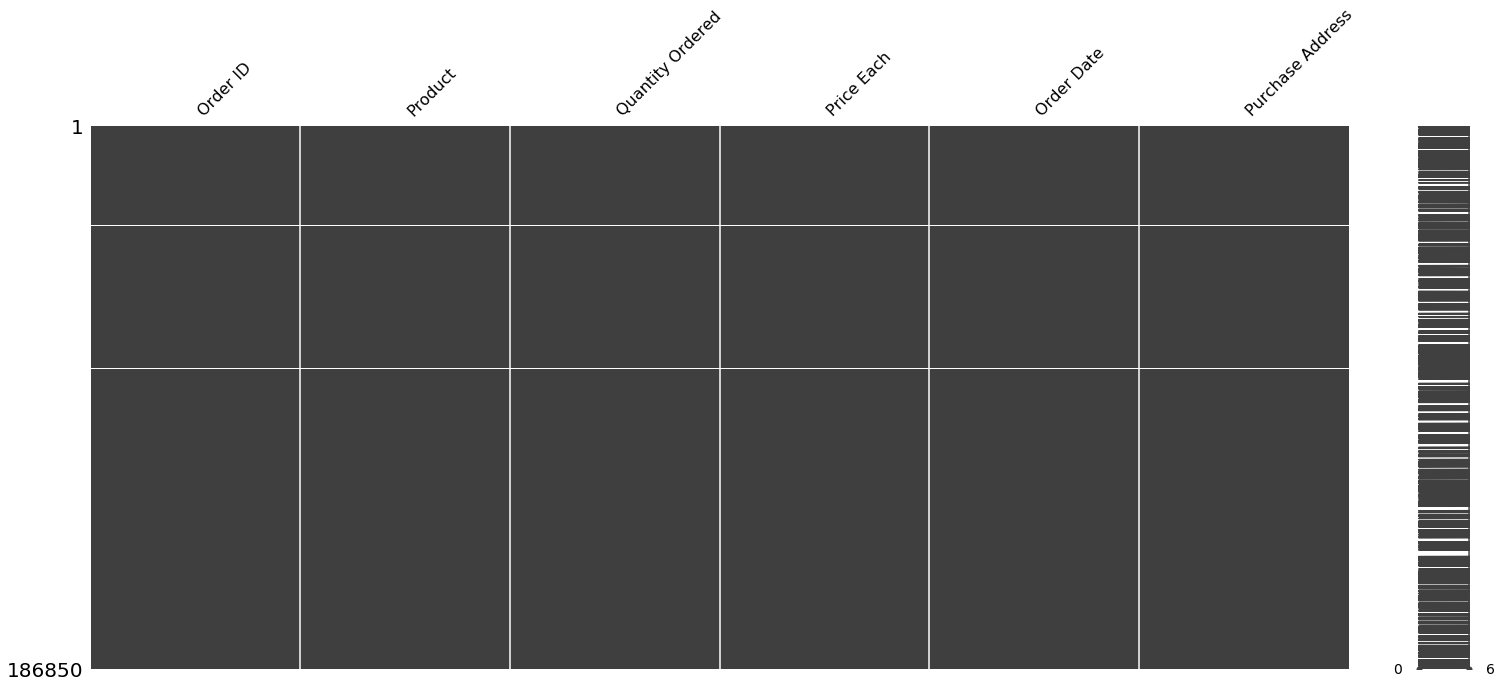

In [13]:
#visualizing null values
%matplotlib inline  
figure = plt.figure(figsize=(30,30))
msno.matrix(sales_data)

It looks like taht some rows' values are entirely NaNs. It makes sense. According to results that I got, I think that there are 545 rows whose values are entirely null. 

In [14]:
#like this
sales_data[sales_data.isnull().all(axis=1)].head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
1,NaN,NaN,NaN,NaN,NaN,NaN
356,NaN,NaN,NaN,NaN,NaN,NaN
735,NaN,NaN,NaN,NaN,NaN,NaN
1433,NaN,NaN,NaN,NaN,NaN,NaN
1553,NaN,NaN,NaN,NaN,NaN,NaN


There are 545 rows whose values are all null. On the other hand, other rows do not contain any null values in them. 

I think that there are no ways to impute the 545 rows and imputing is not a good idea for some of numerical columns of this dataset. Moreover, they are only about 0.3 % of all data. Therefore, I will drop the rows from our dataset. 

In [15]:
# drop rows containing null values 
sales_data.dropna(inplace=True)

In [16]:
sales_data.isnull().sum()

Order ID            0
Product             0
Quantity Ordered    0
Price Each          0
Order Date          0
Purchase Address    0
dtype: int64

No NaNs in our dataset

In [17]:
index = sales_data[sales_data['Order ID']=='Order ID'].index

When I tried to change dtypes of ```Order ID```, ```Quantity Ordered```, and ```Price Each``` columns, I got an error. Then, I figured out that 355 rows have their columns names in them. I will drop them 

In [18]:
#like this
print(len(sales_data[sales_data['Order ID']=='Order ID']))
sales_data[sales_data['Order ID']=='Order ID'].head()

355


,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
519,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
1149,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
1155,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
2878,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
2893,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address


In [19]:
#drop the 355 rows
sales_data = sales_data.drop(index)

Now, we are ready to change dypes

In [20]:
#change dtypes
sales_data['Order ID'] = sales_data['Order ID'].astype('int')

In [21]:
#change dtypes of two columns to float
sales_data[['Quantity Ordered','Price Each']]=sales_data[['Quantity Ordered','Price Each']].astype('float')

In [22]:
#change dtype of order data to datetime
sales_data['Order Date']=pd.to_datetime(sales_data['Order Date'])

In [23]:
sales_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 185950 entries, 0 to 186849
Data columns (total 6 columns):
Order ID            185950 non-null int32
Product             185950 non-null object
Quantity Ordered    185950 non-null float64
Price Each          185950 non-null float64
Order Date          185950 non-null datetime64[ns]
Purchase Address    185950 non-null object
dtypes: datetime64[ns](1), float64(2), int32(1), object(2)
memory usage: 9.2+ MB


Then, calculate summary statistics to see if there are extreme values 

In [24]:
sales_data.describe()

,Order ID,Quantity Ordered,Price Each
count,185950.000000,185950.000000,185950.000000
mean,230417.569379,1.124383,184.399735
std,51512.737110,0.442793,332.731330
min,141234.000000,1.000000,2.990000
25%,185831.250000,1.000000,11.950000
50%,230367.500000,1.000000,14.950000
75%,275035.750000,1.000000,150.000000
max,319670.000000,9.000000,1700.000000


In [25]:
sales_data['Quantity Ordered'].value_counts()

1.0    168552
2.0     13324
3.0      2920
4.0       806
5.0       236
6.0        80
7.0        24
8.0         5
9.0         3
Name: Quantity Ordered, dtype: int64

In [26]:
sales_data['Price Each'].value_counts()

11.95      21903
14.95      21658
2.99       20641
3.84       20577
11.99      18882
150.00     15549
99.99      13325
149.99      7507
700.00      6842
600.00      6837
389.99      6230
379.99      6181
300.00      4800
1700.00     4724
999.99      4128
109.99      4101
400.00      2065
Name: Price Each, dtype: int64

It seems that there are no strange values in ```Quantity Ordered``` and ```Price Each```. 

In [27]:
sales_data['Product'].value_counts()

USB-C Charging Cable          21903
Lightning Charging Cable      21658
AAA Batteries (4-pack)        20641
AA Batteries (4-pack)         20577
Wired Headphones              18882
Apple Airpods Headphones      15549
Bose SoundSport Headphones    13325
27in FHD Monitor               7507
iPhone                         6842
27in 4K Gaming Monitor         6230
34in Ultrawide Monitor         6181
Google Phone                   5525
Flatscreen TV                  4800
Macbook Pro Laptop             4724
ThinkPad Laptop                4128
20in Monitor                   4101
Vareebadd Phone                2065
LG Washing Machine              666
LG Dryer                        646
Name: Product, dtype: int64

All kinds of products are properly classified by names; there is no product names which describe one item due to typo or other issues. 

#### summary of inspection ####

- Since all of dtypes were object, I made changes on some of the dtypes. For Order ID, I changed it to ```int```. For Quantity Ordered and Price Each, I changed them to ```float```. Then, finally, I changed Order Date to ```datetime```.

- Since there were 545 rows containing null values, I dropped the rows. 

- Since there were 355 rows containing columns names, I dropped the rows.

- There are no strange values in numerical columns. 

### Data Cleaning###
Although I have already done getting rid of null values and dtype conversion, I will fix problems with this dataset.

In [28]:
sales_data.columns = sales_data.columns.str.replace(" ",'_').str.lower()

Replaced white spaces with underscore and lower columns' names

In [29]:
sales_data.head()

,order_id,product,quantity_ordered,price_each,order_date,purchase_address
0,176558,USB-C Charging Cable,2.0,11.95,2019-04-19 08:46:00,"917 1st St, Dallas, TX 75001"
2,176559,Bose SoundSport Headphones,1.0,99.99,2019-04-07 22:30:00,"682 Chestnut St, Boston, MA 02215"
3,176560,Google Phone,1.0,600.00,2019-04-12 14:38:00,"669 Spruce St, Los Angeles, CA 90001"
4,176560,Wired Headphones,1.0,11.99,2019-04-12 14:38:00,"669 Spruce St, Los Angeles, CA 90001"
5,176561,Wired Headphones,1.0,11.99,2019-04-30 09:27:00,"333 8th St, Los Angeles, CA 90001"


In [30]:
sales_data=sales_data.reset_index(drop=True)

Reset int index

In [31]:
sales_data.head()

,order_id,product,quantity_ordered,price_each,order_date,purchase_address
0,176558,USB-C Charging Cable,2.0,11.95,2019-04-19 08:46:00,"917 1st St, Dallas, TX 75001"
1,176559,Bose SoundSport Headphones,1.0,99.99,2019-04-07 22:30:00,"682 Chestnut St, Boston, MA 02215"
2,176560,Google Phone,1.0,600.00,2019-04-12 14:38:00,"669 Spruce St, Los Angeles, CA 90001"
3,176560,Wired Headphones,1.0,11.99,2019-04-12 14:38:00,"669 Spruce St, Los Angeles, CA 90001"
4,176561,Wired Headphones,1.0,11.99,2019-04-30 09:27:00,"333 8th St, Los Angeles, CA 90001"


## Task 1##
### What was the best month for sales? How much was earned that month?###


In [32]:
# making a column describing total sale for each order. 
sales_data['total'] = sales_data['quantity_ordered']*sales_data['price_each']

In [33]:
sales_data.head()

,order_id,product,quantity_ordered,price_each,order_date,purchase_address,total
0,176558,USB-C Charging Cable,2.0,11.95,2019-04-19 08:46:00,"917 1st St, Dallas, TX 75001",23.90
1,176559,Bose SoundSport Headphones,1.0,99.99,2019-04-07 22:30:00,"682 Chestnut St, Boston, MA 02215",99.99
2,176560,Google Phone,1.0,600.00,2019-04-12 14:38:00,"669 Spruce St, Los Angeles, CA 90001",600.00
3,176560,Wired Headphones,1.0,11.99,2019-04-12 14:38:00,"669 Spruce St, Los Angeles, CA 90001",11.99
4,176561,Wired Headphones,1.0,11.99,2019-04-30 09:27:00,"333 8th St, Los Angeles, CA 90001",11.99


In [34]:
#using month attribute for groupby since it is faster than using strftime
monthly_sales = sales_data.groupby(sales_data['order_date'].dt.month)

In [35]:
each_month = monthly_sales['total'].sum()

In [36]:
each_month.sort_values(ascending = False)

order_date
12    4.613443e+06
10    3.736727e+06
4     3.390670e+06
11    3.199603e+06
5     3.152607e+06
3     2.807100e+06
7     2.647776e+06
6     2.577802e+06
8     2.244468e+06
2     2.202022e+06
9     2.097560e+06
1     1.822257e+06
Name: total, dtype: float64

Text(0, 0.5, 'total sale')

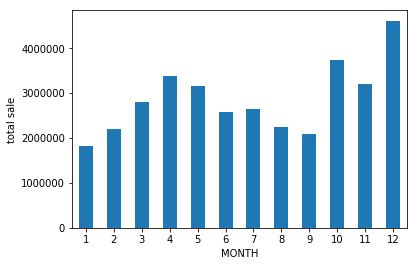

In [37]:
each_month.plot.bar()
plt.xlabel('MONTH')
plt.xticks(rotation=0)
plt.ylabel('total sale')

In [38]:
each_month[12]/each_month[1]

2.5317197429155613

In [39]:
each_month[12]/each_month[10]

1.2346214984811348

According to this result, December is the best month for sales. It is about $4613000.
It is 2.5 times as big as sales of January. Even when I compare the Dec sales with Oct sales, it is still 1.2 times bigger. I think that this completely makes sense. For instance, December have some special days, such as Christmas. 

## Task 2 ##
### What city sold the most product?###

In [40]:
sales_data.head()

,order_id,product,quantity_ordered,price_each,order_date,purchase_address,total
0,176558,USB-C Charging Cable,2.0,11.95,2019-04-19 08:46:00,"917 1st St, Dallas, TX 75001",23.90
1,176559,Bose SoundSport Headphones,1.0,99.99,2019-04-07 22:30:00,"682 Chestnut St, Boston, MA 02215",99.99
2,176560,Google Phone,1.0,600.00,2019-04-12 14:38:00,"669 Spruce St, Los Angeles, CA 90001",600.00
3,176560,Wired Headphones,1.0,11.99,2019-04-12 14:38:00,"669 Spruce St, Los Angeles, CA 90001",11.99
4,176561,Wired Headphones,1.0,11.99,2019-04-30 09:27:00,"333 8th St, Los Angeles, CA 90001",11.99


In [41]:
#create a regex to get city names from address
regex=r'[\w\s]+,([\w\s]+),[\w\s]+'

In [42]:
city = sales_data.groupby(sales_data['purchase_address'].str.extract(regex,expand=False))

In [43]:
product_by_city=city['quantity_ordered'].sum().sort_values(ascending=False)

Text(0, 0.5, 'num of products sold')

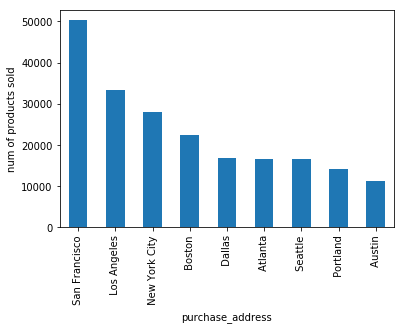

In [44]:
product_by_city.plot.bar()
plt.ylabel('num of products sold')

In [45]:
product_by_city[' San Francisco']/product_by_city[' Los Angeles']

1.509177205683559

According to this figure, it is obvious that, in San Francisco, the largerst number of products is sold. Since the products are sold in electonics stores, I can assume that they are some kind of electronics. Therefore, since the city is really famous for information technology, it does make sense that the largest number of products is sold in there. 
Specifically, the number of sales in San Francisco is 1.5 times as large as Los Angeles. 

## Task 3 ##
### What time should we display advertisements to maximize the likelihood of customer’s buying product?###

In [46]:
sales_data.head()

,order_id,product,quantity_ordered,price_each,order_date,purchase_address,total
0,176558,USB-C Charging Cable,2.0,11.95,2019-04-19 08:46:00,"917 1st St, Dallas, TX 75001",23.90
1,176559,Bose SoundSport Headphones,1.0,99.99,2019-04-07 22:30:00,"682 Chestnut St, Boston, MA 02215",99.99
2,176560,Google Phone,1.0,600.00,2019-04-12 14:38:00,"669 Spruce St, Los Angeles, CA 90001",600.00
3,176560,Wired Headphones,1.0,11.99,2019-04-12 14:38:00,"669 Spruce St, Los Angeles, CA 90001",11.99
4,176561,Wired Headphones,1.0,11.99,2019-04-30 09:27:00,"333 8th St, Los Angeles, CA 90001",11.99


I will group data based on hour. I think that it is important to figure out specific time when we want to display advertisements to miximize the likelihood instead of finding time in an abstract way, such as morning, noon, and night.

In [47]:
sales_data_hour = sales_data.groupby(sales_data['order_date'].dt.hour)

In [48]:
hourly_orders = sales_data_hour['order_id'].count()

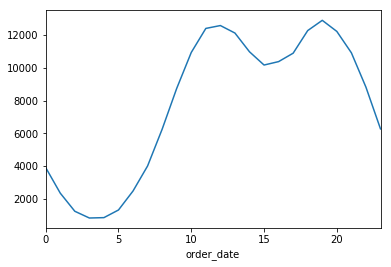

In [49]:
#see the trend with line 
hourly_orders.plot(kind='line')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23]), <a list of 24 Text xticklabel objects>)

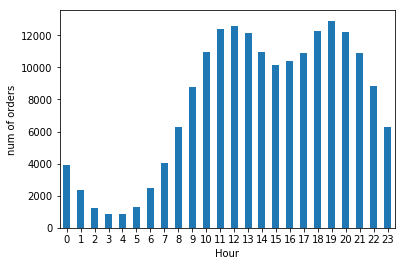

In [50]:
hourly_orders.plot(kind='bar')
plt.xlabel('Hour')
plt.ylabel('num of orders')
plt.xticks(rotation=360)

This graph shows a relationship between the number of orders and hours. It can be observed that there are two peaks of the number of orders. They are around 12 around 19(7PM). On the other hand, the number of the orders reaches its bottom at 3 and 4. 
Therefore, it is better to display advertisements around 12 and 19 since it is more likely that many customers will see ads at thoese time. Then, at times when the number of orders is really small, I would recommed to reuduce the number of ads. 
However, to really maximize the likelifood of customers' buying products, it is good idea to collect other factors of each order, such as gender of buyers and their age. This will help us to display more ads attractive to customers. 

## Task 4 ##
### What products are most often sold together? ###

In [51]:
sales_data.head()

,order_id,product,quantity_ordered,price_each,order_date,purchase_address,total
0,176558,USB-C Charging Cable,2.0,11.95,2019-04-19 08:46:00,"917 1st St, Dallas, TX 75001",23.90
1,176559,Bose SoundSport Headphones,1.0,99.99,2019-04-07 22:30:00,"682 Chestnut St, Boston, MA 02215",99.99
2,176560,Google Phone,1.0,600.00,2019-04-12 14:38:00,"669 Spruce St, Los Angeles, CA 90001",600.00
3,176560,Wired Headphones,1.0,11.99,2019-04-12 14:38:00,"669 Spruce St, Los Angeles, CA 90001",11.99
4,176561,Wired Headphones,1.0,11.99,2019-04-30 09:27:00,"333 8th St, Los Angeles, CA 90001",11.99


In [52]:
#get only rows whose order_id are duplicated
duplicated_id  = sales_data[sales_data.duplicated(subset='order_id',keep=False)]

In [53]:
from itertools import chain, combinations
from collections import Counter

In [54]:
duplicated_id.head()

,order_id,product,quantity_ordered,price_each,order_date,purchase_address,total
2,176560,Google Phone,1.0,600.00,2019-04-12 14:38:00,"669 Spruce St, Los Angeles, CA 90001",600.00
3,176560,Wired Headphones,1.0,11.99,2019-04-12 14:38:00,"669 Spruce St, Los Angeles, CA 90001",11.99
17,176574,Google Phone,1.0,600.00,2019-04-03 19:42:00,"20 Hill St, Los Angeles, CA 90001",600.00
18,176574,USB-C Charging Cable,1.0,11.95,2019-04-03 19:42:00,"20 Hill St, Los Angeles, CA 90001",11.95
29,176585,Bose SoundSport Headphones,1.0,99.99,2019-04-07 11:31:00,"823 Highland St, Boston, MA 02215",99.99


In [55]:
duplicated_grouped = duplicated_id.groupby('order_id')

In [56]:
#asked a question regarding this code in https://stackoverflow.com/questions/62038142/counting-the-number-of-pairs-of-items-in-a-grouped-dataframes-column-pandas
def all_subsets(items):
    return chain(*map(lambda x:combinations(items,x),range(2,len(items)+1)))

In [57]:
k = [tuple(sorted(z)) for y in duplicated_grouped['product'].apply(all_subsets) for z in y]

In [58]:
Counter(k).most_common(10)

[(('Lightning Charging Cable', 'iPhone'), 1015),
 (('Google Phone', 'USB-C Charging Cable'), 999),
 (('Wired Headphones', 'iPhone'), 462),
 (('Google Phone', 'Wired Headphones'), 423),
 (('Apple Airpods Headphones', 'iPhone'), 373),
 (('USB-C Charging Cable', 'Vareebadd Phone'), 368),
 (('Bose SoundSport Headphones', 'Google Phone'), 228),
 (('USB-C Charging Cable', 'Wired Headphones'), 205),
 (('Vareebadd Phone', 'Wired Headphones'), 149),
 (('Lightning Charging Cable', 'Wired Headphones'), 129)]

The most common combination of items is a pair of "Lightning Charging Cable" and "iphone". It makes sense because they are compliment goods. Same thing is also applied to a pair of "Google Phone" and 'USB-C Charging Cable'. You can actually see that most of combinations listed above have a relationship of compliment goods.

## Task 5 ##
### What product sold the most? Why do you think it sold the most? ###

In [59]:
sales_data.head()

,order_id,product,quantity_ordered,price_each,order_date,purchase_address,total
0,176558,USB-C Charging Cable,2.0,11.95,2019-04-19 08:46:00,"917 1st St, Dallas, TX 75001",23.90
1,176559,Bose SoundSport Headphones,1.0,99.99,2019-04-07 22:30:00,"682 Chestnut St, Boston, MA 02215",99.99
2,176560,Google Phone,1.0,600.00,2019-04-12 14:38:00,"669 Spruce St, Los Angeles, CA 90001",600.00
3,176560,Wired Headphones,1.0,11.99,2019-04-12 14:38:00,"669 Spruce St, Los Angeles, CA 90001",11.99
4,176561,Wired Headphones,1.0,11.99,2019-04-30 09:27:00,"333 8th St, Los Angeles, CA 90001",11.99


In [60]:
product_grouped = sales_data.groupby('product')

In [61]:
product_amount=product_grouped['quantity_ordered'].agg('sum').sort_values()

In [62]:
product_amount

product
LG Dryer                        646.0
LG Washing Machine              666.0
Vareebadd Phone                2068.0
20in Monitor                   4129.0
ThinkPad Laptop                4130.0
Macbook Pro Laptop             4728.0
Flatscreen TV                  4819.0
Google Phone                   5532.0
34in Ultrawide Monitor         6199.0
27in 4K Gaming Monitor         6244.0
iPhone                         6849.0
27in FHD Monitor               7550.0
Bose SoundSport Headphones    13457.0
Apple Airpods Headphones      15661.0
Wired Headphones              20557.0
Lightning Charging Cable      23217.0
USB-C Charging Cable          23975.0
AA Batteries (4-pack)         27635.0
AAA Batteries (4-pack)        31017.0
Name: quantity_ordered, dtype: float64

Text(0, 0.5, 'quantity sold')

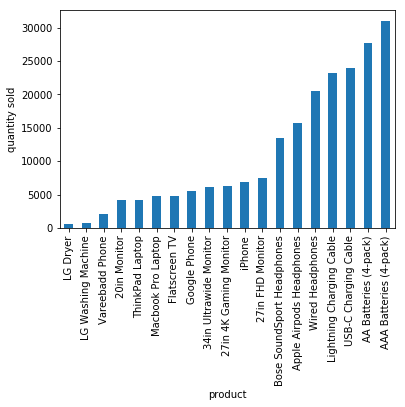

In [63]:
product_amount.plot.bar()
plt.ylabel('quantity sold')

Batteries are sold the most and charging cables are also sold a lot. I think that this is because they are items which are often nedded to be replaced with new ones. Moreover, there are many situations where batteries are used in daily life. On the other hand, as for other items whose quantities sold are not large, you can realize that they are products which you use for years, such as phones and monitors. Therefore, products sold a lot have characteristics that they are often used in daily life and replaced with new ones. 